# Applying motion magnification to solar data

This notebook will demonstrate how to apply motion magnification to EUV imaging data of the solar corona, in the search for the ubiquitous decayless kink oscillations.

In [ ]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
%pip install dtcwt
import dtcwt
from google.colab import drive  # Access google drive files
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dtcwt: filename=dtcwt-0.12.0-py3-none-any.whl size=87869 sha256=aa7281b4cf80dd1730f5faf86b83cb11c92312be3f8b0bfb554b88f5a172476f
  Stored in directory: /root/.cache/pip/wheels/af/50/50/cf98b0e08812889d0f5789d271acbdab7ac7c3086c323a8e0a
Successfully built dtcwt
Mounted at /content/gdrive


In [ ]:
%pip install sunpy
%pip install sunpy-soar # This is necessary, do not forget!
import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a

from astropy.coordinates import SkyCoord
from astropy import units as u

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.8 MB/s eta 0:00:00


First we must choose some SDO/AIA 171$Å$ data to download. Here I first get a whole sun map and search for an active region, since we are looking for clearly contrasted coronal loops.
As a suggestion, you could try an example of a blowout jet as analysed in [Sukarmadji, Antolin & McLaughlin 2022](https://iopscience.iop.org/article/10.3847/1538-4357/ac7870#apjac7870f4) on  2014 May 3, around 03:10, and look for yourself to see if any small amplitude transverse waves are present (and discuss with the authors)!

For this example I have used a random time from last Sunday, and use the [JSOC client](https://docs.sunpy.org/en/v5.0.0/generated/api/sunpy.net.jsoc.JSOCClient.html) to fetch data - feel free to change.

In [ ]:
# I personally dislike Fido...
#time_range = a.Time('2023/06/11 00:00:38', '2023/06/11 00:00:51')
#params_171 = a.Instrument.aia & a.Wavelength(171*u.angstrom)
#params_hmi = a.Instrument.hmi & a.Physobs.los_magnetic_field
#res = Fido.search(time_range, params_171 | params_hmi)  # in this case res[0,0] is 171 & res[1,0] is hmi

from sunpy.net import jsoc
client = jsoc.JSOCClient()

time_range = a.Time('2023/06/11 00:00:38', '2023/06/11 00:00:39')
email = a.jsoc.Notify('tim.duckenfield@northumbria.ac.uk')
params_aia = a.jsoc.Series('aia.lev1_euv_12s') & a.Wavelength(171*u.AA)
params_hmi = a.jsoc.Series('hmi.m_720s') # magnetogram. Maybe change?

response = client.search(time_range, params_aia | params_hmi, email)
res = client.fetch(response,path='/) # Save the full frames somewhere

Export request pending. [id=JSOC_20230620_1665, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20230621_416, status=2]
Waiting for 0 seconds...
Export request pending. [id=JSOC_20230621_416, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230621_416, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230621_416, status=1]
Waiting for 5 seconds...
Export request pending. [id=JSOC_20230621_416, status=1]
Waiting for 5 seconds...
3 URLs found for download. Full request totalling 13MB


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

aia.lev1_euv_12s.2023-06-11T000046Z.171.image_lev1.fits:   0%|          | 0.00/11.9M [00:00<?, ?B/s]

aia.lev1_euv_12s.2023-06-11T000046Z.171.spikes.fits:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

hmi.m_720s.20230611_000000_TAI.3.magnetogram.fits:   0%|          | 0.00/13.9M [00:00<?, ?B/s]

Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2023-06-11 00:00:45
Exposure Time,1.9995969999999996 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.59948897 0.59948897] arcsec / pix
Reference Pixel,[2051.44946 2049.81812] pix

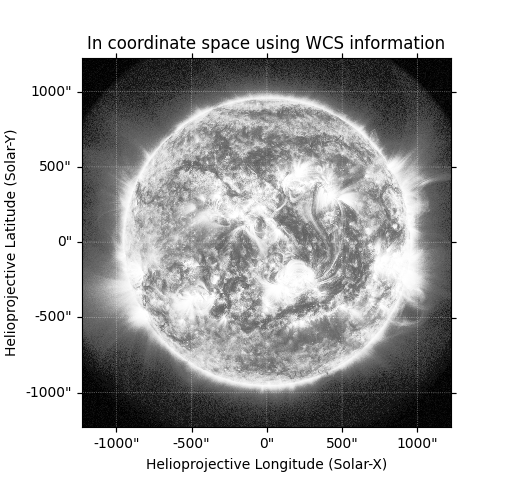
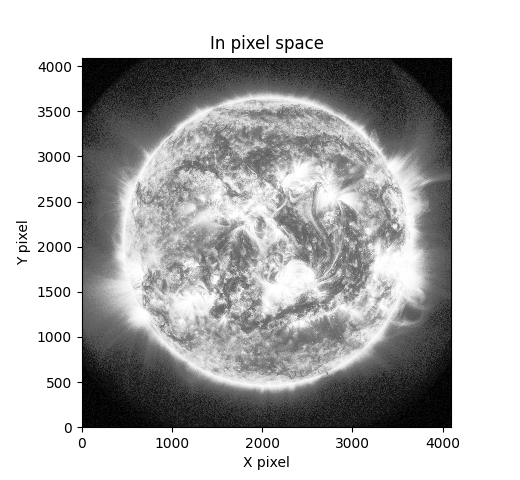
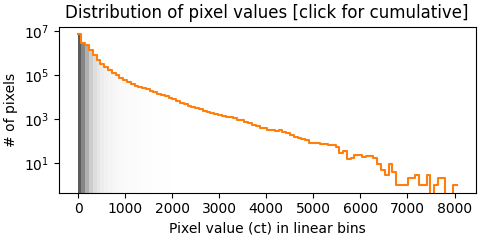
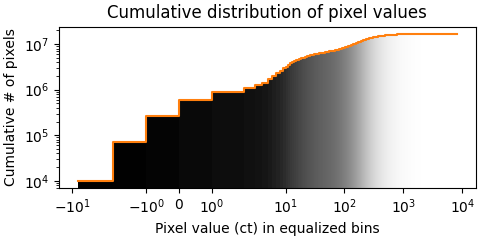

In [ ]:
import sunpy.map
import sunpy.data.sample

my_map_171 = sunpy.map.Map('/content/aia.lev1_euv_12s.2023-06-11T000046Z.171.image_lev1.fits')
my_map_hmi = sunpy.map.Map('/content/hmi.m_720s.20230611_000000_TAI.3.magnetogram.fits')
my_map_combined = sunpy.map.Map(my_map_171, my_map_hmi, composite=True)

#my_map.quicklook() # SunPy does have a nice quicklook feature!
my_map_171

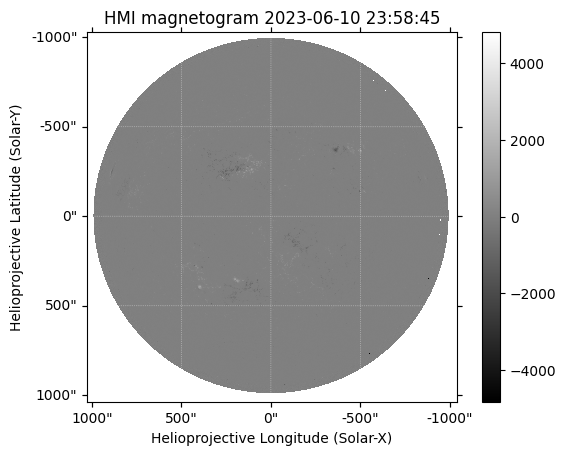

In [ ]:
# Plot HMI
fig = plt.figure()
ax = fig.add_subplot(projection=my_map_hmi)
my_map_hmi.plot(axes=ax)
plt.colorbar()
plt.show()

In [ ]:
# Combined not working for some reason?
#levels = [-1000, -500, -250, 250, 500, 1000] * u.G
#my_map_combined.set_levels(index=1, levels=levels)

#fig = plt.figure()
#ax = fig.add_subplot(projection=my_map_combined.get_map(0))
#my_map_combined.plot(axes=ax)
#plt.show()

Now we should extract a suitable [cut out](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/downloading_cutouts.html#sphx-glr-generated-gallery-acquiring-data-downloading-cutouts-py). This is because motion magnifying a huge dataset such as full sun images (4096 x 4096) would take a very long time, and likely lead to memory crashes.

We should select a region with clear, visible inhomogeneities which do not move around fast.

/usr/local/lib/python3.10/dist-packages/astropy/visualization/wcsaxes/patches.py:197: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


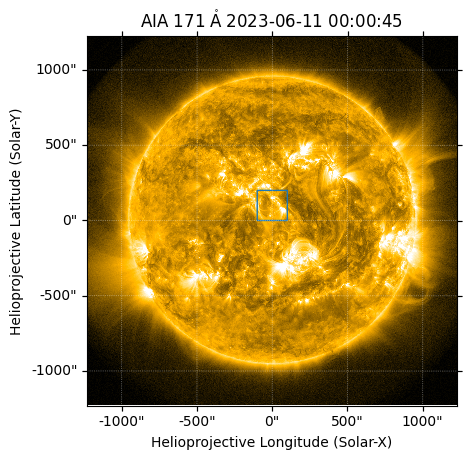

In [ ]:
# Specify region of interest.
roi_bottom_left = SkyCoord(Tx=-100*u.arcsec, Ty=0*u.arcsec, frame=my_map_171.coordinate_frame)
roi_top_right = SkyCoord(Tx=100*u.arcsec, Ty=200*u.arcsec, frame=my_map_171.coordinate_frame)
fig = plt.figure()
ax = fig.add_subplot(projection=my_map_171)
my_map_171.plot(axes=ax, clip_interval=(1,99.5)*u.percent)
my_map_171.draw_quadrangle(roi_bottom_left, top_right=roi_top_right, axes=ax, color='C0')
plt.show()

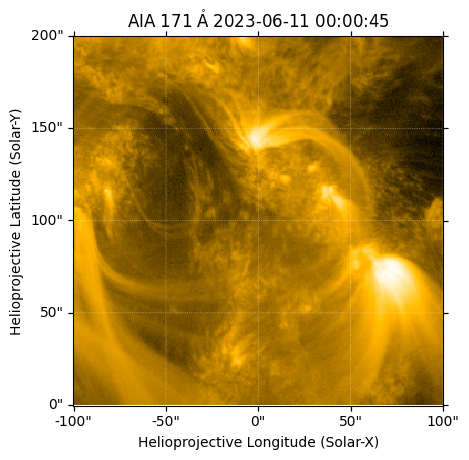

In [ ]:
my_submap = my_map_171.submap(roi_bottom_left, top_right=roi_top_right)

fig = plt.figure()
ax = fig.add_subplot(projection=my_submap)
my_submap.plot(axes=ax)
plt.show()

Now we will fetch a [cutout](https://docs.sunpy.org/en/stable/generated/api/sunpy.net.jsoc.attrs.Cutout.html#sunpy.net.jsoc.attrs.Cutout) of this data.

This requires a registered email address with jsoc (feel free to use mine for this tutorial).

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch

import sunpy.coordinates  # NOQA
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as a

start_time = Time('2023-06-11T00:00:00', scale='utc', format='isot')
jsoc_email = 'tim.duckenfield@northumbria.ac.uk'

# Set tracking to True and register to True (for smoother tracking)
cutout = a.jsoc.Cutout(roi_bottom_left, top_right=roi_top_right, tracking=True, register=True)
query = Fido.search(
    a.Time(start_time -0.4*u.h, start_time + 0.4*u.h),
    a.Wavelength(171*u.angstrom),
    a.Sample(12*u.s),
    a.jsoc.Series.aia_lev1_euv_12s,
    a.jsoc.Notify(jsoc_email),
    a.jsoc.Segment.image,
    cutout,
)
print(query) # See which files will be downloaded

Results from 1 Provider:

241 Results from the JSOCClient:
Source: http://jsoc.stanford.edu

       T_REC         TELESCOP INSTRUME WAVELNTH CAR_ROT
-------------------- -------- -------- -------- -------
2023-06-10T23:35:59Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:36:11Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:36:23Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:36:35Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:36:47Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:36:59Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:37:11Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:37:23Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:37:35Z  SDO/AIA    AIA_3      171    2271
2023-06-10T23:37:47Z  SDO/AIA    AIA_3      171    2271
                 ...      ...      ...      ...     ...
2023-06-11T00:21:59Z  SDO/AIA    AIA_3      171    2271
2023-06-11T00:22:11Z  SDO/AIA    AIA_3      171    2271
2023-06-11T00:22:23Z  SDO/AIA    AIA_3      171    2271
2023-06-11T

Now download the data. This can take a little while,depending on the cutout size. I have included my (very crude) code for this example dataset, but I have also saved the fits files in folder `fits/orig_fits`.

In [ ]:
#files = Fido.fetch(query)
#files.sort()
#sq171_20230611 = sunpy.map.Map(files, sequence=True)

# Save FITS files
#sq171_20230611.save('/content/gdrive/MyDrive/orig_fits/20230611_{index:03}.fits')

In [ ]:
# Alternatively just load sequence from saved fits
files_2 = '/content/gdrive/MyDrive/orig_fits/20230611_*.fits'  # Check location
sq171_20230611 = sunpy.map.Map(files_2, sequence=True)

Now let us visualise this to check it looks okay.

All maps are the same shape:  True


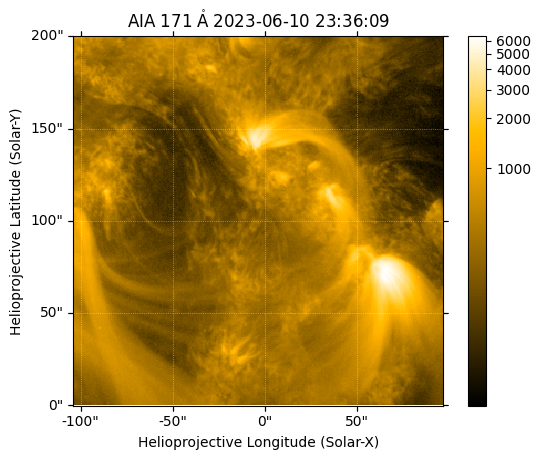

In [ ]:
print("All maps are the same shape: ",sq171_20230611.all_maps_same_shape())
#print("Each of the ",np.size(files_2)," files have a size of ",sq171_20230611[0].shape)
fig = plt.figure()
ax = fig.add_subplot(projection=sq171_20230611[0])
sq171_20230611[0].plot(axes=ax)
plt.colorbar()
plt.show()

Let us save out this map sequence as an mp4.

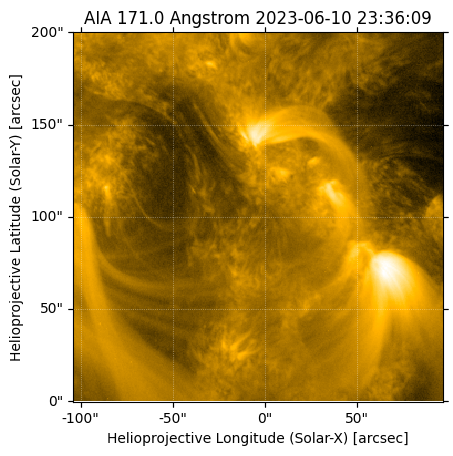

In [ ]:
import matplotlib.animation as animation

ani = sq171_20230611.plot()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='SunPy'), bitrate=1800)
ani.save('/content/gdrive/MyDrive/orig_fits/20230611_sunmaps.mp4', writer=writer)  #'/content/20230611_sunmaps.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Show video
mp4 = open('/content/gdrive/MyDrive/orig_fits/20230611_sunmaps.mp4','rb').read()  #'/content/20230611_sunmaps.mp4'
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

Now we have some data, let us convert it to a numpy array, in order to perform the motion magnification.

In [ ]:
# Convert into a numpy array. Note we change order so frames are first.
sq = np.transpose(sq171_20230611.as_array(),(2,0,1))
sq.shape

(241, 334, 334)

In [ ]:
# Motion magnify
%pip install dtcwt
!git clone https://github.com/Sergey-Anfinogentov/motion_magnification.git
%cd /content/motion_magnification
from magnify import *

k = 5      # Pick a magnification factor
width= 120 # width
sq_20230611_k5w120 = magnify_motions_2d(sq, k, width) # Be sure to choose appropriate name.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'motion_magnification' already exists and is not an empty directory.
/content/motion_magnification
Forward DTCWT... DONE
Modifying phase... DONE
Inverse DTCWT... DONE


Now we save out the magnified data as FITS files, using the original files' header information. Then we can read those FITS files in to create another map sequence.

I have done this **very** inelegantly! If you know a way of either: avoiding a `for` loop here; extracting the header directly from a map (or map sequence); or adding a header to an array to make a map sequence directly, please let me know!

In [ ]:
import astropy.io.fits
nframes = sq_20230611_k5w120.shape[0]
for i in range(nframes):
  head = astropy.io.fits.getheader('/content/gdrive/MyDrive/temp_files/20230611_'+str(i).zfill(3)+'.fits')
  my_map = sunpy.map.Map(sq_20230611_k5w120[i,:,:] ,head)
  my_map.save('/content/gdrive/MyDrive/temp_files/20230611_k5w120_'+str(i).zfill(3)+'.fits',overwrite=True)
  #print("saving to"+'/content/gdrive/MyDrive/temp_files/20230611_k5w120_'+str(i).zfill(3)+'.fits')

/content/gdrive/MyDrive/temp_files/20239611_000.fits
/content/gdrive/MyDrive/temp_files/20239611_001.fits
/content/gdrive/MyDrive/temp_files/20239611_002.fits
/content/gdrive/MyDrive/temp_files/20239611_003.fits
/content/gdrive/MyDrive/temp_files/20239611_004.fits
/content/gdrive/MyDrive/temp_files/20239611_005.fits
/content/gdrive/MyDrive/temp_files/20239611_006.fits
/content/gdrive/MyDrive/temp_files/20239611_007.fits
/content/gdrive/MyDrive/temp_files/20239611_008.fits
/content/gdrive/MyDrive/temp_files/20239611_009.fits
/content/gdrive/MyDrive/temp_files/20239611_010.fits
/content/gdrive/MyDrive/temp_files/20239611_011.fits
/content/gdrive/MyDrive/temp_files/20239611_012.fits
/content/gdrive/MyDrive/temp_files/20239611_013.fits
/content/gdrive/MyDrive/temp_files/20239611_014.fits
/content/gdrive/MyDrive/temp_files/20239611_015.fits
/content/gdrive/MyDrive/temp_files/20239611_016.fits
/content/gdrive/MyDrive/temp_files/20239611_017.fits
/content/gdrive/MyDrive/temp_files/20239611_01

In [ ]:
# Make map sequence of the magnified data
files_mm = '/content/gdrive/MyDrive/temp_files/20239611_k5w120_*.fits'
sq171_k5w120_20230611 = sunpy.map.Map(files_mm, sequence=True)

All maps are the same shape:  True


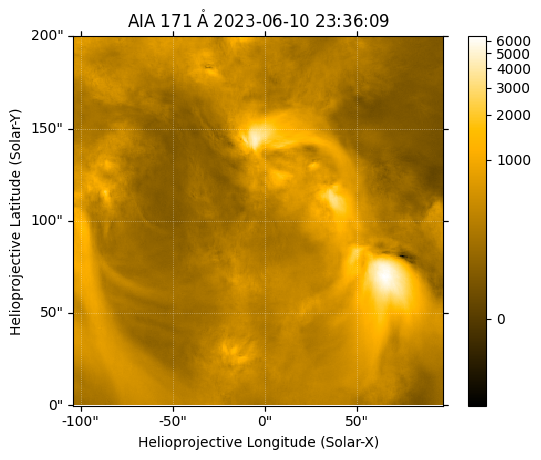

In [ ]:
print("All maps are the same shape: ",sq171_k5w120_20230611.all_maps_same_shape())
fig = plt.figure()
ax = fig.add_subplot(projection=sq171_k5w120_20230611[0])
sq171_k5w120_20230611[0].plot(axes=ax)
plt.colorbar()
plt.show()

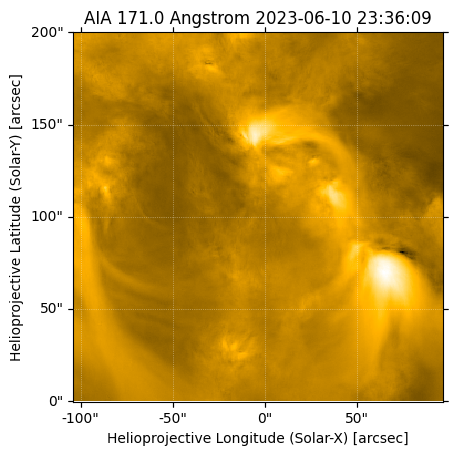

In [ ]:
ani_mm = sq171_k5w120_20230611.plot()
#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='SunPy'), bitrate=1800)
ani_mm.save('/content/20230611_k5w120_sunmaps.mp4', writer=writer)

In [ ]:
# Show video
mp4 = open('/content/20230611_k5w120_sunmaps.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ani_mm = sq_20230611_k5w120.plot()
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='SunPy'), bitrate=1800)
ani_mm.save('/content/20230611_sunmaps_k5w120.mp4', writer=writer)

In [ ]:
np.save('/content/gdrive/MyDrive/20230611_171.npy',sq)
np.save('/content/gdrive/MyDrive/20230611_171_magk5w120.npy',sq_k5w120)